In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

# 1 创建有向图

## 1.1 生成图当中各个节点的度

In [2]:
def generate_degree_sequence(n):
    # 生成度数
    degrees = []
    while len(degrees) < n:
        degree = int(np.ceil(np.random.power(2.5) * 100))  # 根据幂律分布生成度数
        if 2 <= degree <= 20:
            degrees.append(degree)
    # 确保总度数为偶数
    total_degree = sum(degrees)
    if total_degree % 2 != 0:
        degrees[random.randint(0, n - 1)] += 1
    return degrees

# 生成度数序列
degrees = generate_degree_sequence(1000)

## 1.2 生成一个无向的MutiGraph

In [3]:
def create_directed_graph(degrees):
    G = nx.MultiGraph()
    G.add_nodes_from([i for i in range(1000)])
    for i, degree in enumerate(degrees):
        # 将节点与其余节点随机连接，直到达到所需的度数
        while G.degree(i) < degree:
            j = random.randint(0, len(degrees) - 1)
            if i != j and G.degree(j) < 20:  # 确保不连接自身且不超过最大度数
                G.add_edge(i, j)
    return G

undirected_G = create_directed_graph(degrees)

## 1.3 将图像变为有向图

In [4]:
def convert_to_directed_graph(G):
    directed_G = nx.DiGraph()
    for edge in G.edges():
        if random.choice([True, False]):  # 随机将无向边转换为有向边
            directed_G.add_edge(edge[0], edge[1])
        else:
            directed_G.add_edge(edge[1], edge[0])
    return directed_G

directed_G = convert_to_directed_graph(undirected_G)

## 1.4 画有向图

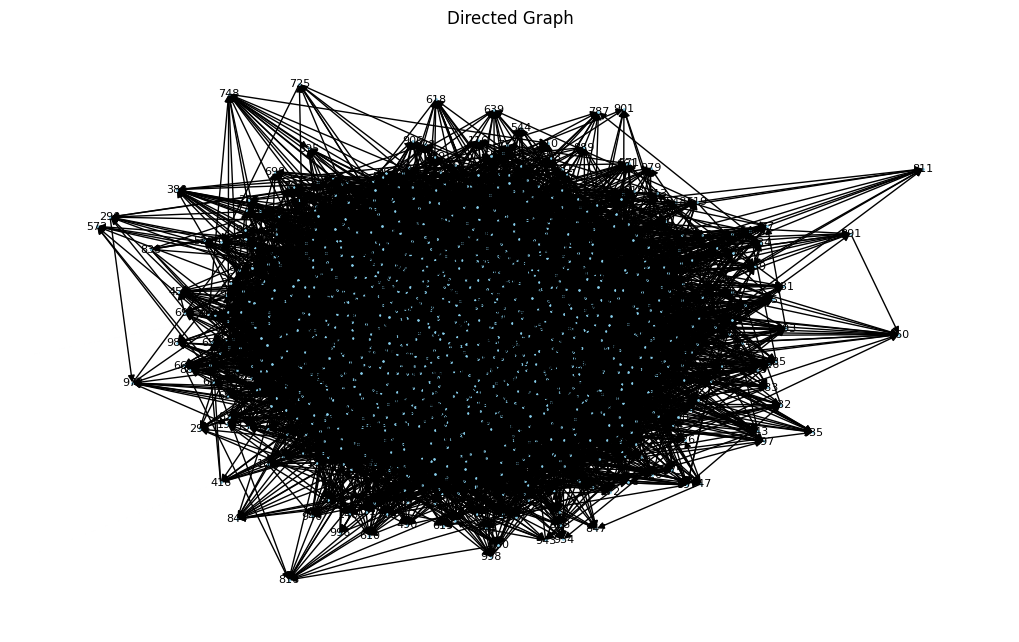

In [20]:
# 画图
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(directed_G)
nx.draw(directed_G, pos, with_labels=True, node_size=1, node_color="skyblue", font_size=8)
plt.title("Directed Graph")
plt.show()

# 2 PageRank

## 2.1 实现pagerank

In [5]:
def pagerank_iteration(graph, beta=0.85, max_iter=100, tol=1e-6):
    # 初始化PageRank
    N = len(graph)
    pagerank = {node: 1/N for node in graph.nodes()}
    
    # 迭代更新PageRank值
    for _ in range(max_iter):
        new_pagerank = {}
        for node in graph.nodes():
            new_pagerank[node] = (1 - beta) / N
            for neighbor in graph.predecessors(node):
                new_pagerank[node] += beta * pagerank[neighbor] / graph.out_degree(neighbor)
        
        # 检查PageRank是否收敛
        diff = sum(abs(new_pagerank[node] - pagerank[node]) for node in graph.nodes())
        if diff < tol:
            break
        
        pagerank = new_pagerank
        
    # 归一化
    sum_pagerank = sum(pagerank.values())
    pagerank_normalized = {node: rank / sum_pagerank for node, rank in pagerank.items()}
    
    return pagerank_normalized

pagerank=pagerank_iteration(directed_G)
pagerank_df = pd.DataFrame(list(pagerank.items()),columns=["Node","value"])
pagerank_df = pagerank_df.sort_values(by="value",ascending=False)
pagerank_df.head(10)

,Node,value
638,954,0.001904
748,269,0.001817
580,910,0.001810
19,619,0.001799
1,0,0.001795
935,673,0.001768
79,41,0.001748
828,203,0.001729
503,852,0.001723
440,70,0.001696


## 2.2 度与重要性的相关系数，图

In [6]:
# 将每个节点度的信息和重要性进行合并
degrees_df=pd.DataFrame(list(dict(directed_G.degree()).items()),columns=["Node","Degree"])
pagerank_df = pd.DataFrame(list(pagerank.items()),columns=["Node","Rank"])
outdegrees_df=pd.DataFrame(list(dict(directed_G.out_degree()).items()),columns=["Node","outDegree"])
indegrees_df=pd.DataFrame(list(dict(directed_G.in_degree()).items()),columns=["Node","inDegree"])
degree_rank = pd.concat([degrees_df, pagerank_df["Rank"], outdegrees_df["outDegree"], indegrees_df["inDegree"]], axis=1)

# 计算度和排名之间的相关系数
correlation_degree_rank = degree_rank['Degree'].corr(degree_rank['Rank'])

# 计算出度和排名之间的相关系数
correlation_outdegree_rank = degree_rank['outDegree'].corr(degree_rank['Rank'])

# 计算入度和排名之间的相关系数
correlation_indegree_rank = degree_rank['inDegree'].corr(degree_rank['Rank'])

print("Correlation between degree and rank:", correlation_degree_rank)
print("Correlation between outdegree and rank:", correlation_outdegree_rank)
print("Correlation between indegree and rank:", correlation_indegree_rank)

Correlation between degree and rank: 0.49972699618097866
Correlation between outdegree and rank: -0.28269845560675905
Correlation between indegree and rank: 0.8604696279114797


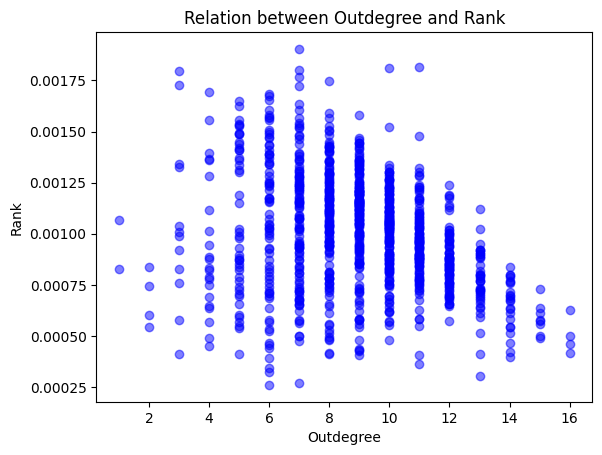

In [7]:
plt.scatter(degree_rank["outDegree"], degree_rank["Rank"], color='blue', alpha=0.5)
plt.title('Relation between Outdegree and Rank')
plt.xlabel('Outdegree')
plt.ylabel('Rank')
plt.show()

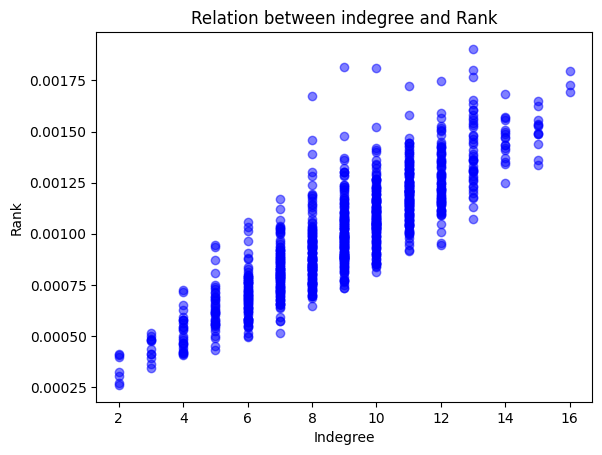

In [8]:
plt.scatter(degree_rank["inDegree"], degree_rank["Rank"], color='blue', alpha=0.5)
plt.title('Relation between indegree and Rank')
plt.xlabel('Indegree')
plt.ylabel('Rank')
plt.show()

# 3 Spam Farm

## 3.1 实现Spam Farm

In [10]:
import random
import networkx as nx

def add_spam_to_existing_graph(graph, num_spam_pages, num_links_per_page,spy):
    # 创建一个新的图对象
    graph_1 = nx.DiGraph()
    graph_1.add_nodes_from(graph.nodes)  # 将原始图的节点添加到新图中
    graph_1.add_edges_from(graph.edges)  # 将原始图的边添加到新图中

    # 存储待添加的边
    edges_to_add = []

    # 添加大量的低质量页面（节点）
    spam_nodes = [f"spam_{i}" for i in range(num_spam_pages)]
    graph_1.add_nodes_from(spam_nodes)

    # 互相链接低质量页面
    for node in spam_nodes:
        # 随机选择一些其他页面进行链接
        linked_pages = random.sample(spam_nodes, min(num_links_per_page, len(spam_nodes)))
        for linked_page in linked_pages:
            if linked_page != node:  # 确保不链接到自身
                edges_to_add.append((node, linked_page))

    # 链接到目标网站
    target_website = "target"
    for node in spam_nodes:
        edges_to_add.append((node, target_website))

    # 添加边到图中
    graph_1.add_edges_from(edges_to_add)

    # 在原始图中随机选取固定数量的节点，并将它们链接到垃圾节点
    for node in spy:
        graph_1.add_edge(node, "target")

    return graph_1

# 设置参数
num_spam_pages = 100  # 垃圾页面数量
num_links_per_page = 3  # 每个页面链接数量
spy_nodes = random.sample(list(directed_G.nodes()),10)
# 向原始图中添加垃圾邮件农场
graph_spam = add_spam_to_existing_graph(directed_G, num_spam_pages, num_links_per_page,spy_nodes)

# 计算新的pagerank值
pagerank_new_spam = pagerank_iteration(graph_spam)
pagerank_df_spam = pd.DataFrame(list(pagerank_new_spam.items()), columns=["Node", "value"])
pagerank_df_spam = pagerank_df_spam.sort_values(by="value", ascending=False).reset_index(drop=True)
pagerank_df_spam.head(10)


,Node,value
0,target,0.009391
1,954,0.001811
2,269,0.001729
3,910,0.001724
4,619,0.001714
5,0,0.001710
6,673,0.001682
7,41,0.001664
8,203,0.001644
9,852,0.001640


## 3.2 计算farm网页数和trank值的系数

In [26]:
t=[]
for m in range(5,105,5):
    num_spam_pages = m  # 垃圾页面数量
    num_links_per_page = 3  # 每个页面链接数量
    graph_spam_3 = add_spam_to_existing_graph(directed_G, num_spam_pages, num_links_per_page,spy_nodes)
    pagerank = pagerank_iteration(graph_spam_3)
    t.append((m,pagerank["target"]))

Correlation between node and rank: 0.9998954177181969


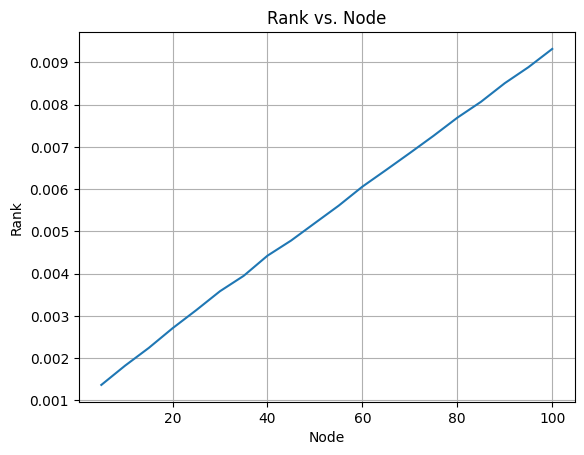

In [27]:
nodes, ranks = zip(*t)

# 计算相关系数
correlation = np.corrcoef(nodes, ranks)[0, 1]
print("Correlation between node and rank:", correlation)

#画图
plt.plot(nodes, ranks)
plt.xlabel('Node')
plt.ylabel('Rank')
plt.title('Rank vs. Node')
plt.grid(True)
plt.show()


# 4.TrustRank

## 4.1TrustRank算法实现

In [28]:
# 用矩阵的形式来实现trustrank算法
def trust_rank(graph, seed_nodes, damping_factor=0.85, max_iterations=100, tolerance=1e-6):
    # 构建节点到整数索引的映射
    node_mapping = {node: i for i, node in enumerate(graph.nodes())}
    
    # 初始化信任值向量
    num_nodes = len(graph)
    v = np.zeros(num_nodes)
    for node in seed_nodes:
        v[node_mapping[node]] = 1.0 / len(seed_nodes)  # 均匀分配初始信任值
    
    # 构建转移矩阵
    T = np.zeros((num_nodes, num_nodes))
    for node in graph:
        out_links = list(graph.successors(node))  # 使用successors获取节点的出链
        if out_links:
            for out_link in out_links:
                out_link_index = node_mapping[out_link]  # 使用节点映射来获取整数索引
                T[out_link_index][node_mapping[node]] = 1.0 / len(out_links)  # 出链的节点分配均匀的传递信任值
    
    # 迭代更新信任值向量
    temp = v.copy()
    for _ in range(max_iterations):
        temp = v.copy()
        v = damping_factor * np.dot(T, v) + (1 - damping_factor) * v  # TrustRank算法的迭代公式
        if np.linalg.norm(temp - v) < tolerance:  # 检查是否收敛
            break
    
    # 返回节点的TrustRank值
    trust_rank_values = {node: v[node_mapping[node]] for node in graph}
    return trust_rank_values

# 从这个列表中随机选择20个不重复的数

seed_nodes = random.sample(list(set(range(1000)) - set(spy_nodes)), 20)

# Calculate TrustRank values
tr_values = trust_rank(graph_spam, seed_nodes)

print(seed_nodes)

[721, 267, 915, 80, 547, 987, 157, 229, 98, 306, 998, 823, 156, 627, 412, 961, 797, 76, 545, 69]


In [29]:
tr_rank_df = pd.DataFrame(list(tr_values.items()),columns=["Node","TrustRank"])
tr_rank_df = tr_rank_df.sort_values(by="TrustRank",ascending=False)
tr_rank_df.reset_index(drop=True, inplace=True)
tr_rank_df.loc[999:,:]

,Node,TrustRank
999,892,0.000143
1000,766,0.000104
1001,spam_53,0.000000
1002,spam_54,0.000000
1003,spam_73,0.000000
...,...,...
1096,spam_30,0.000000
1097,spam_29,0.000000
1098,spam_28,0.000000
1099,spam_26,0.000000


In [30]:
tr_rank_df[tr_rank_df["Node"]=="target"]

,Node,TrustRank
639,target,0.00081


# 5 Adjust Pagerank

## 5.1 实现

In [31]:
def adjustPageRank(pagerank,trustrank):
    adjust={}
    for m,n in pagerank.items():
        adjust[m]=n*trustrank[m]
    
    return adjust

pagerank_trust = adjustPageRank(pagerank_new_spam,tr_values)

pagerank_df_new = pd.DataFrame(list(pagerank_trust.items()), columns=["Node", "value"])
pagerank_df_new = pagerank_df_new.sort_values(by="value", ascending=False)
pagerank_df_new.reset_index(drop=True, inplace=True)
pagerank_df_new.head()

,Node,value
0,target,0.000008
1,59,0.000004
2,105,0.000003
3,368,0.000003
4,52,0.000003


## 5.2 Spam Mass

In [32]:
def calculate_seed_pagerank(graph, seed_nodes, damping_factor=0.85, max_iterations=100, tolerance=1e-6):
    # Initialize PageRank values for all nodes
    pagerank_values = {node: 1 if node in seed_nodes else 0 for node in graph}

    # Iteratively update PageRank values
    for _ in range(max_iterations):
        new_pagerank_values = pagerank_values.copy()

        for node in graph:
            if node in seed_nodes:
                if graph.out_degree(node) > 0:
                    pagerank_contribution = damping_factor * pagerank_values[node] / graph.out_degree(node)
                    for successor in graph.successors(node):
                        new_pagerank_values[successor] = new_pagerank_values.get(successor) + pagerank_contribution

        # Check convergence
        if all(abs(new_pagerank_values[node] - pagerank_values[node]) < tolerance for node in graph):
            break

        pagerank_values = new_pagerank_values

    return pagerank_values

def normalize_dict_values(input_dict):
    # Calculate the sum of all values
    total_sum = sum(input_dict.values())

    # Normalize values
    normalized_dict = {key: value / total_sum for key, value in input_dict.items()}

    return normalized_dict

seed_nodes = random.sample(list(range(1000)), 20)
temp1 = normalize_dict_values(calculate_seed_pagerank(graph_spam, seed_nodes))

temp2 = pd.DataFrame(list(temp1.items()), columns=["Node", "value+"])

temp3 = pd.merge(pagerank_df_spam,temp2,on="Node")

temp3["spam_mass"]=(temp3["value"]-temp3["value+"])/temp3["value"]

temp3=temp3.sort_values(by="spam_mass",ascending=False)

filtered_rows = temp3[temp3['Node'].astype(str).str.contains('spam_')]
filtered_rows

,Node,value,value+,spam_mass
747,spam_61,0.000775,0.0,1.0
816,spam_9,0.000722,0.0,1.0
786,spam_13,0.000750,0.0,1.0
556,spam_69,0.000912,0.0,1.0
823,spam_90,0.000713,0.0,1.0
...,...,...,...,...
960,spam_47,0.000547,0.0,1.0
965,spam_15,0.000541,0.0,1.0
967,spam_73,0.000540,0.0,1.0
930,spam_75,0.000600,0.0,1.0


In [33]:
temp3[temp3["Node"]=="target"]

,Node,value,value+,spam_mass
0,target,0.009277,0.0,1.0
